# Actividad 1

In [1]:
import torch
import torch.nn as nn

In [2]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1)
    
    def forward(self, input_):
        batch_size = input_.size()[0]
        h0 = self.init_hidden(batch_size)
        _, last_hidden = self.rnn(input_.unsqueeze(2), h0)
        out = self.linear_out(last_hidden.squeeze())
        return out        
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

In [79]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### 1) num. parámetros de RNN(1,5,1)

Primero consideremos la ecuación del hidden state usada por nn.RNN (fuente: https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN)
$$ h_t = \text{tanh}(W_{ih}x_t + b_{ih} + W_{hh}h_{(t-1)} + b_{hh}) $$

La matriz $W_{ih}$ sería de dimensiones 5x1 y el bias $b_{ih}$ de 5x1 también.

La matriz $W_{hh}$ sería de 5x5 y el bias $b_{hh}$ de 5x1.
Esto nos da un total de $5+5+25+5=40$ variables entrenables por parte de nn.RNN.

Si además consideramos el nn.Linear que se aplica al último hidden state, ahí tenemos una matriz de pesos de 5x1 más un bias de 1x1.
Así, da un total de $40+5+1=46$ variables entrenables.

Esto lo podemos corroborar empíricamente:


In [8]:
model = RNN(1, 5, 1)
num_trainable_parameters(model)

46

#### 2) num. parámetros de RNN(1,4,1)

Siguiendo el mismo razonamiento anterior:

La matriz $W_{ih}$ sería de dimensiones 4x1 y el bias $b_{ih}$ de 4x1 también.

La matriz $W_{hh}$ sería de 4x4 y el bias $b_{hh}$ de 4x1.
Esto nos da un total de $4+4+16+4=28$ variables entrenables por parte de nn.RNN.

A su vez el nn.Linear aportaría con una matriz de pesos de 4x1 más un bias de 1x1.
Así, da un total de $28+4+1=33$ variables entrenables.

Comprobamos empíricamente:

In [9]:
model = RNN(1, 4, 1)
num_trainable_parameters(model)

33

# Actividad 2

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [9]:
def display_results(dataset, targets, predictions, val_start_idx, test_start_idx):
    # Desnormalizar los valores
    targets_inverse = dataset.inverse_normalize(targets)
    predictions_inverse = dataset.inverse_normalize(predictions)

    # Separar train/val/test
    train_predictions = np.empty_like(predictions)
    train_predictions[:] = np.nan
    train_predictions[:val_start_idx] = predictions_inverse[:val_start_idx]
    if test_start_idx - val_start_idx > 0:
        val_predictions = np.empty_like(predictions)
        val_predictions[:] = np.nan
        val_predictions[val_start_idx:test_start_idx] = predictions_inverse[val_start_idx:test_start_idx]
    test_predictions = np.empty_like(predictions)
    test_predictions[:] = np.nan
    test_predictions[test_start_idx:] = predictions_inverse[test_start_idx:]

    # Imprimir RMSE
    print("Test RMSE: ", math.sqrt(mean_squared_error(targets_inverse[test_start_idx:], predictions_inverse[test_start_idx:])))

    # Graficar targets y predicciones
    fig = plt.figure(figsize=(12, 8))
    plt.plot(targets_inverse, color="blue", label="Original")
    plt.plot(train_predictions, color="green", label="Predicho en entrenamiento")
    if test_start_idx - val_start_idx > 0:
        plt.plot(val_predictions, color="purple", label="Predicho en validación")
    plt.plot(test_predictions, color="red", label="Predicho en test")
    plt.legend(loc="upper left")
    plt.show()
#     plt.savefig("plot.png")

class AirlineDataset(Dataset):
    def __init__(self, dataset_path, input_length):
        super().__init__()
        
        self.input_length = input_length
        
        self._dataset = self._read_dataset(dataset_path)
        self.min_passengers = self._dataset.passengers.min()
        self.max_passengers = self._dataset.passengers.max()
    
    def normalize(self, data):
        return (data - self.min_passengers) / (self.max_passengers - self.min_passengers)
    
    def inverse_normalize(self, data):
        return data * (self.max_passengers - self.min_passengers) + self.min_passengers
        
    def _read_dataset(self, dataset_path):
        dataset_df = pd.read_csv(dataset_path)
        dataset_df.columns = ("month", "passengers")
        return dataset_df
    
    def __len__(self):
        return len(self._dataset) - self.input_length
    
    def __getitem__(self, idx):
        target_idx = idx + self.input_length
        prev_data = self._dataset.iloc[idx:target_idx].passengers.to_numpy()
        target = self._dataset.iloc[target_idx]
        return {
            "prev_data": torch.tensor(self.normalize(prev_data), dtype=torch.float),
            "target": torch.tensor(self.normalize(target.passengers), dtype=torch.float),
            "month": target.month
        }

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

def main():
    # A continuación se definen un par de constantes
    DATASET_PATH = "international-airline-passengers.csv"
    HISTORY_LENGTH = 4
    TEST_START_IDX = 96 - HISTORY_LENGTH
    VAL_SPLIT = 0.1

    INPUT_DIM = 1
    HIDDEN_DIM = 4
    NUM_LAYERS = 1

    EPOCHS = 1000
    BATCH_SIZE = 8
    LEARNING_RATE = 0.005

    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador
    rnn = RNN(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS)
    rnn.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            loss = criterion(predicted.squeeze(), target)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                loss = criterion(predicted.squeeze(), target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 10 == 0:
            print("Epoch #{:>04d}: loss = {:.5f}; val loss = {:.5f}".format(
                epoch, mean_train_loss, mean_val_loss), end='\r', flush=True)

    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            predictions += predicted.squeeze().tolist()
            targets += target.tolist()
            loss = criterion(predicted.squeeze(), target)
            losses.append(loss.item())
        mean_loss = np.mean(losses)    
        
    # Mostrar resultados
    display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
    )

### Ejecutamos el modelo varias veces

Size of train/val/test:  82 10 48
Test RMSE:  67.20986626386845val loss = 0.00430


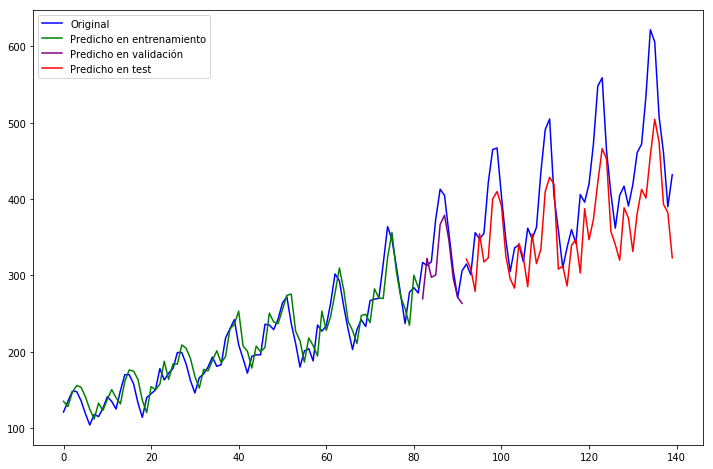

Size of train/val/test:  82 10 48
Test RMSE:  67.33429145763182val loss = 0.00434


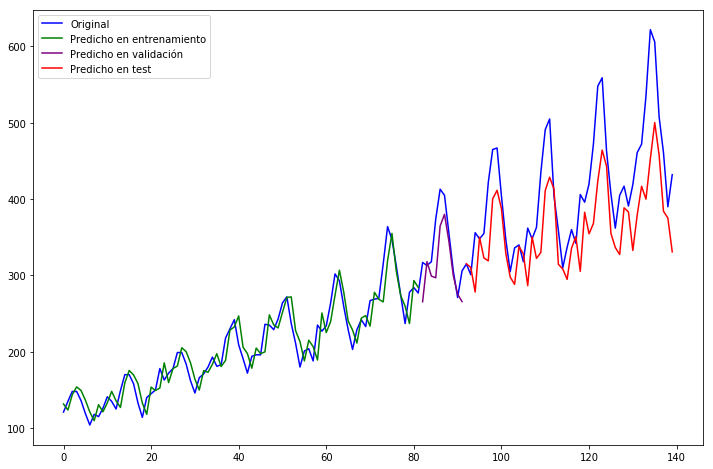

Size of train/val/test:  82 10 48
Test RMSE:  65.82277709853854val loss = 0.00397


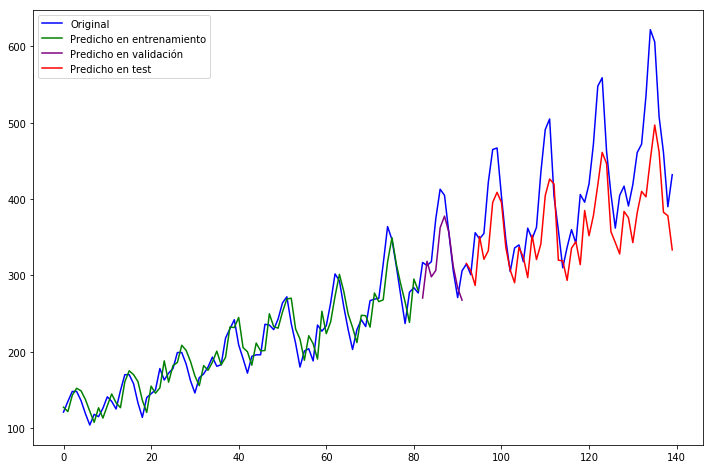

Size of train/val/test:  82 10 48
Test RMSE:  85.6387327667595 val loss = 0.00361


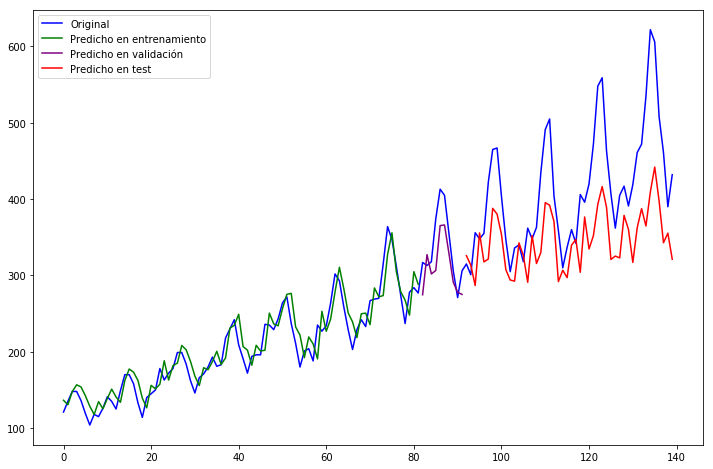

Size of train/val/test:  82 10 48
Test RMSE:  72.27847478458702val loss = 0.00419


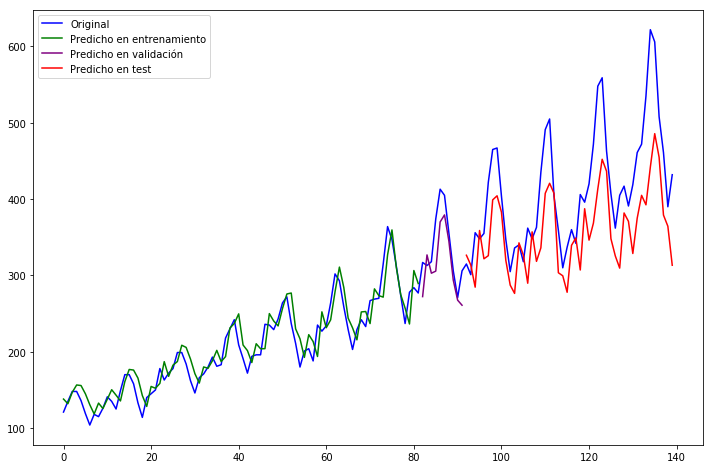

In [10]:
for _ in range(5):
    main()

Notamos que todas las corridas generan resultados distintos aunque más o menos parecidos. Esta variabilidad en los resultados se puede explicar por la presencia de aleatoriedad en el código de entrenamiento. Hay 2 fuentes de aleatoriedad:

- el Dataloader de entrenamiento tiene un ``shuffle=True``
- la inicialización de los pesos también es aleatoria

Otro factor que contribuye a estas diferencias es el hecho de que el set de entrenamiento no es muy grande. Si el set de entrenamiento fuera enorme, en teoría el impacto de la aleatoriedad de los pesos iniciales se debería mitigar con el paso de los epochs ya que todos los modelos tendrían una supervisión más fuerte para converge a aprender lo mismo. Con un dataset más chico hay menos supervisión y por tanto afecta mucho más la lotería de los pesos que le tocaron inicialmente a la red.

### Probando modificaciones

In [14]:
class RNN_modificado(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, use_dense=False, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        
        if (use_dense):
            print('RNN_modificado: using dense(100) before linear')
            self.linear_out = nn.Sequential(
                nn.Linear(hidden_dim, 100),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(100, 1),
            )
        elif dropout > 0:
            print('RNN_modificado: using dropout(%.4f) before linear' % dropout)
            self.linear_out = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, 1),
            )
        else:
            print('RNN_modificado: using just linear (default)')
            self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

In [57]:
def main_modificado(HISTORY_LENGTH=4, use_dense=False, dropout=0.):
    # A continuación se definen un par de constantes
    DATASET_PATH = "international-airline-passengers.csv"
    TEST_START_IDX = 96 - HISTORY_LENGTH
    VAL_SPLIT = 0.1

    INPUT_DIM = 1
    HIDDEN_DIM = 4
    NUM_LAYERS = 1

    EPOCHS = 1000
    BATCH_SIZE = 8
    LEARNING_RATE = 0.005

    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador
    rnn = RNN_modificado(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        use_dense=use_dense,
        dropout=dropout,
    )
    rnn.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            if (len(predicted.shape) > 1):
                predicted = predicted.squeeze()
            loss = criterion(predicted, target)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                if (len(predicted.shape) > 1):
                    predicted = predicted.squeeze()                                
                loss = criterion(predicted, target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 10 == 0:
            print("Epoch #{:>04d}: loss = {:.5f}; val loss = {:.5f}".format(
                epoch, mean_train_loss, mean_val_loss), end='\r', flush=True)

    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            if (len(predicted.shape) > 1):
                predicted = predicted.squeeze()            
            predictions += predicted.tolist()
            loss = criterion(predicted, target)
            targets += target.tolist()            
            losses.append(loss.item())
        mean_loss = np.mean(losses)    
        
    # Mostrar resultados
    display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
    )

### 1) usando distintos HISTORY_LENGTH's

In [55]:
# # DEBUGGING
# import warnings
# with warnings.catch_warnings(record=True) as w:
#     # Cause all warnings to always be triggered.
#     warnings.simplefilter("error")
#     main_modificado(HISTORY_LENGTH=5)

=============== HISTORY_LENGTH = 1 ================
Size of train/val/test:  85 10 48
RNN_modificado: using just linear (default)
Test RMSE:  66.37248252353208val loss = 0.00521


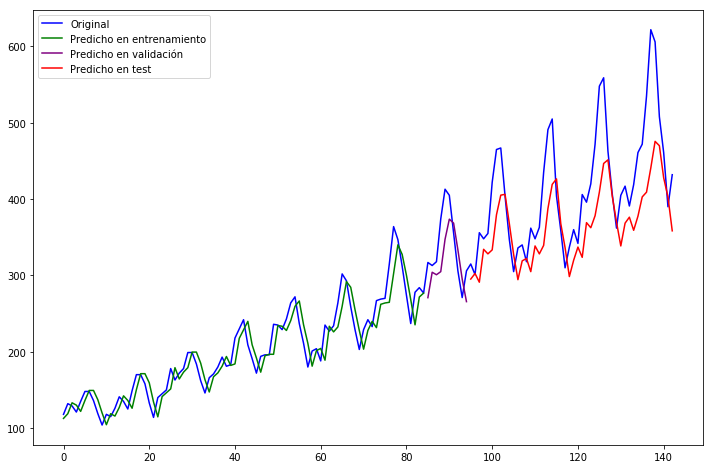

=============== HISTORY_LENGTH = 2 ================
Size of train/val/test:  84 10 48
RNN_modificado: using just linear (default)
Test RMSE:  93.3157685629381 val loss = 0.00532


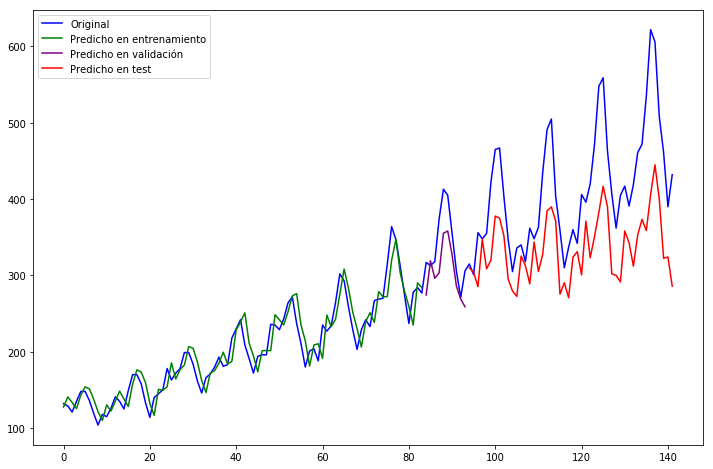

=============== HISTORY_LENGTH = 3 ================
Size of train/val/test:  83 10 48
RNN_modificado: using just linear (default)
Test RMSE:  87.00982445775571val loss = 0.00597


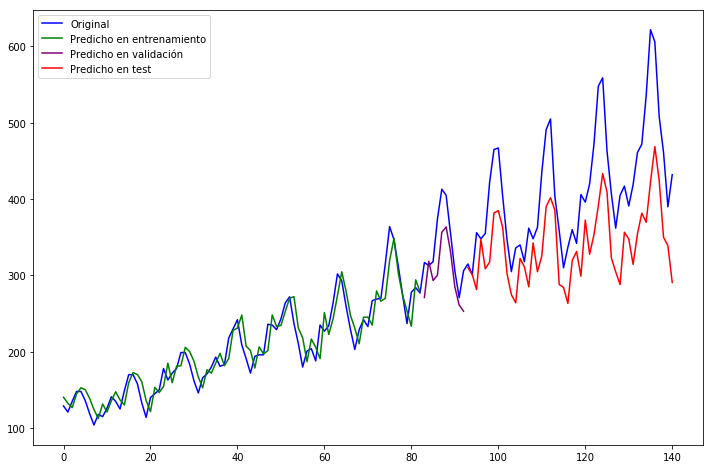

=============== HISTORY_LENGTH = 4 ================
Size of train/val/test:  82 10 48
RNN_modificado: using just linear (default)
Test RMSE:  65.80987675099149val loss = 0.00454


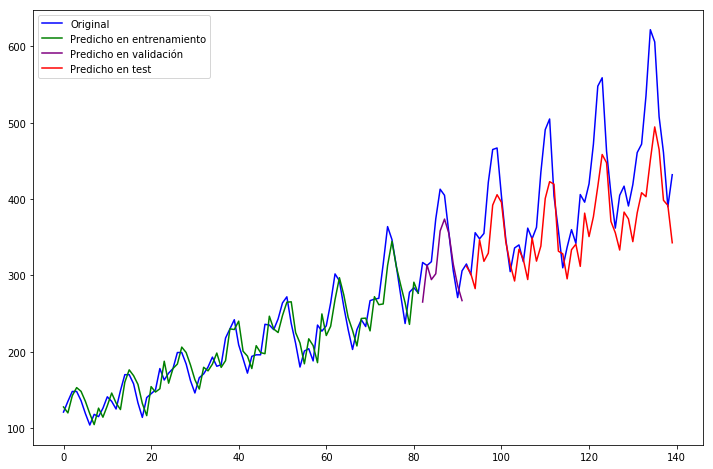

=============== HISTORY_LENGTH = 5 ================
Size of train/val/test:  81 10 48
RNN_modificado: using just linear (default)
Test RMSE:  63.526487177807105al loss = 0.00432


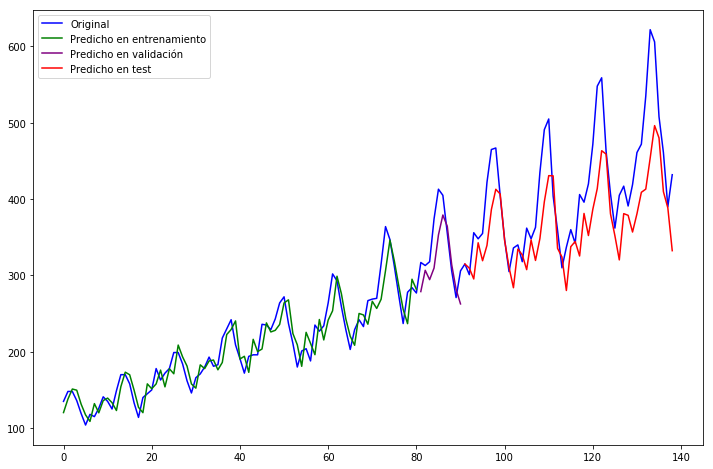

=============== HISTORY_LENGTH = 6 ================
Size of train/val/test:  81 9 48
RNN_modificado: using just linear (default)
Test RMSE:  75.61352634532774val loss = 0.00438


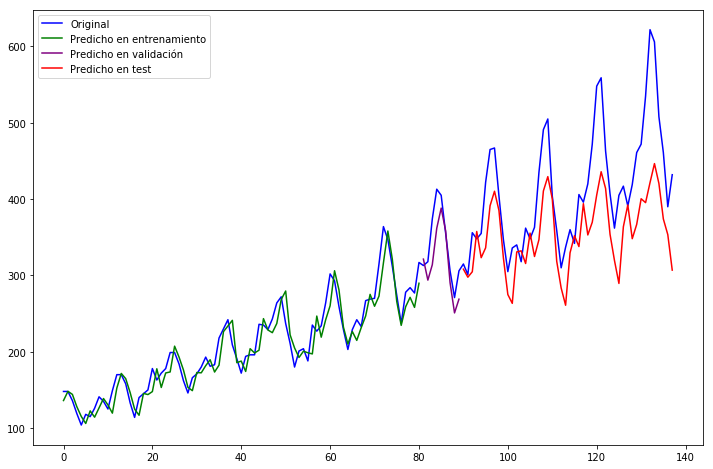

=============== HISTORY_LENGTH = 7 ================
Size of train/val/test:  80 9 48
RNN_modificado: using just linear (default)
Test RMSE:  70.58300681151447val loss = 0.00740


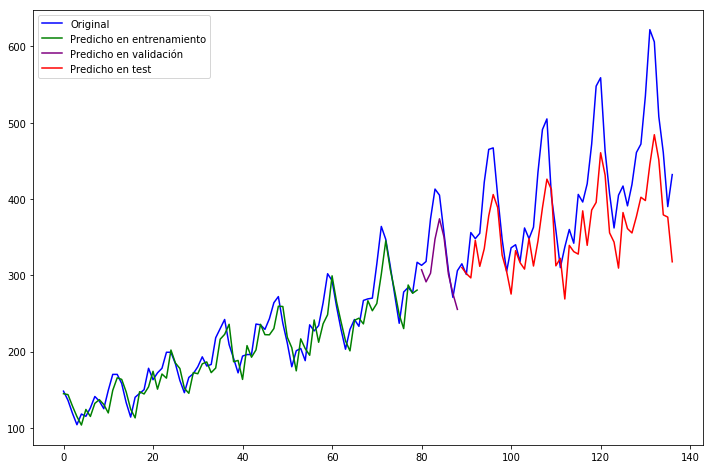

=============== HISTORY_LENGTH = 8 ================
Size of train/val/test:  79 9 48
RNN_modificado: using just linear (default)
Test RMSE:  54.38322933511561val loss = 0.00348


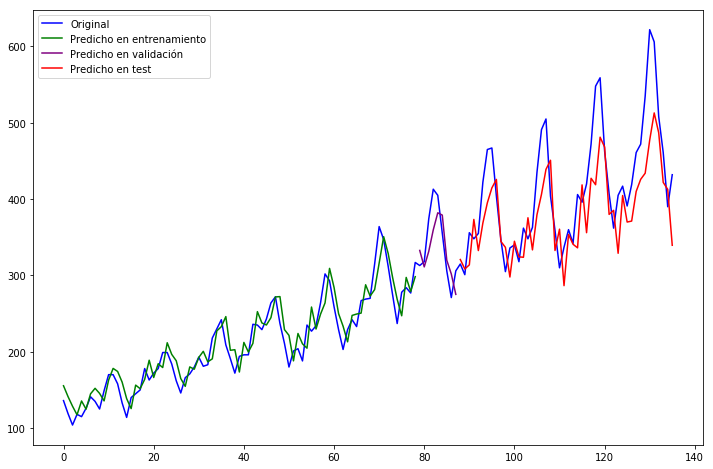

In [58]:
for k in [1,2,3,4,5,6,7,8]:
    print('=============== HISTORY_LENGTH = %d ================' % k)
    main_modificado(HISTORY_LENGTH=k)

=============== HISTORY_LENGTH = 9 ================
Size of train/val/test:  78 9 48
RNN_modificado: using just linear (default)
Test RMSE:  43.93133453471332val loss = 0.00315


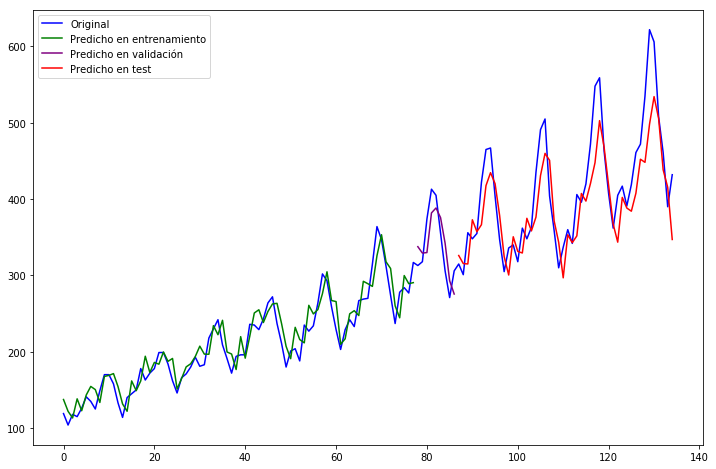

=============== HISTORY_LENGTH = 10 ================
Size of train/val/test:  77 9 48
RNN_modificado: using just linear (default)
Test RMSE:  75.780229562076; val loss = 0.00156


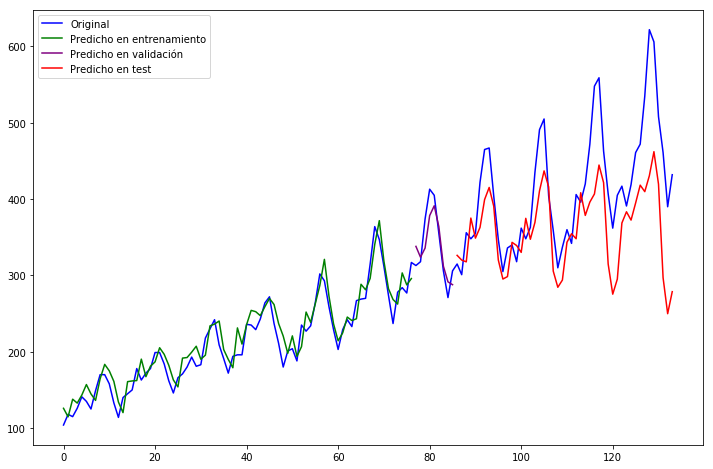

In [59]:
for k in [9,10]:
    print('=============== HISTORY_LENGTH = %d ================' % k)
    main_modificado(HISTORY_LENGTH=k)

Vemos que usar diferentes history lengths no parece tener un patrón de generalización claro a test, a veces mejora y a veces empeora respecto del baseline HISTORY_LENGTH = 4. El mejor resultado se obtuvo con HISTORY_LENGTH = 9 eso sí, con un Test RMSE:  43.93133453471332

### 2) Usando una capa densa de 100 unidades antes del nn.Linear

Size of train/val/test:  82 10 48
RNN_modificado: using dense(100) before linear
Test RMSE:  59.23859177056454val loss = 0.00181


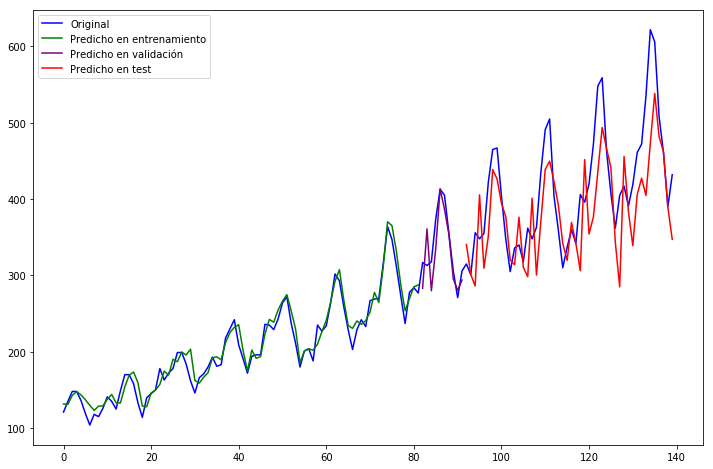

In [60]:
main_modificado(use_dense=True)

Parece que usar una capa densa de 100 unidades antes del nn.Linear mejora un poco los resultados, obteniéndose un Test RMSE de 59.24, un poco mejor que el Test RMSE de 65.82 obtenido sin esta modificación.

### 3) Usando dropout antes del nn.Linear

=============== Dropout = 0.050 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.0500) before linear
Test RMSE:  59.10906037247202val loss = 0.00448


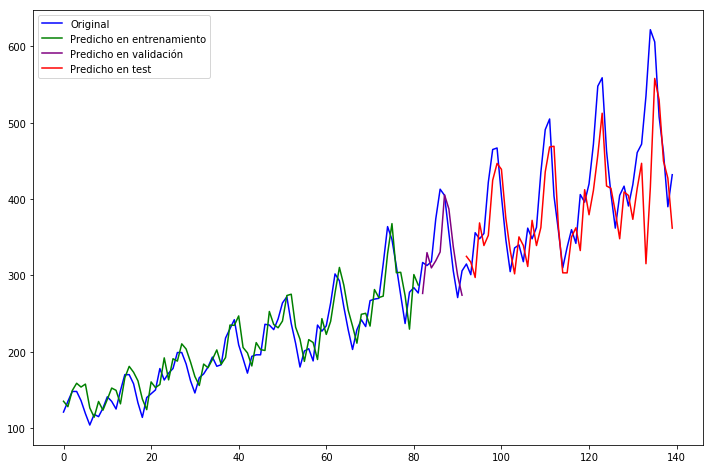

=============== Dropout = 0.100 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.1000) before linear
Test RMSE:  79.93908263317198val loss = 0.00264


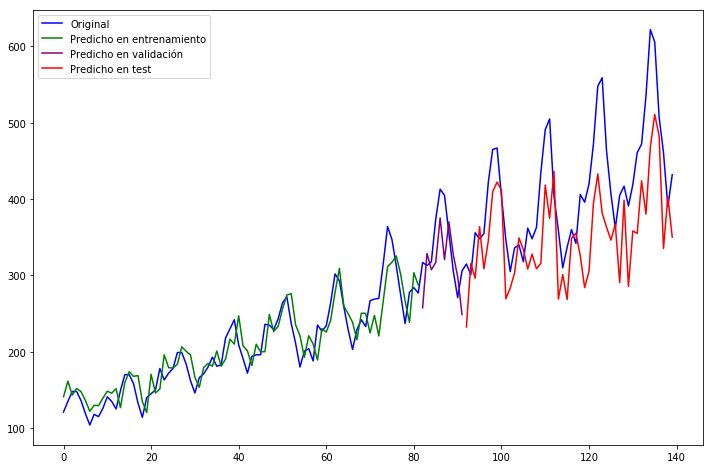

=============== Dropout = 0.200 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.2000) before linear
Test RMSE:  69.32424681222815val loss = 0.00997


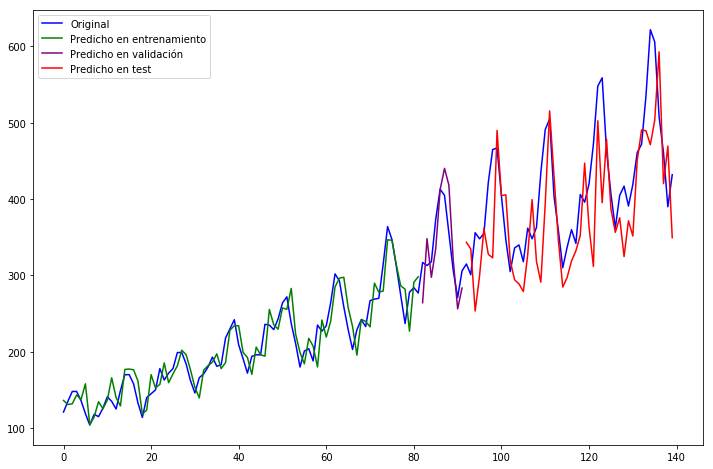

=============== Dropout = 0.300 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.3000) before linear
Test RMSE:  80.57324860918385val loss = 0.01327


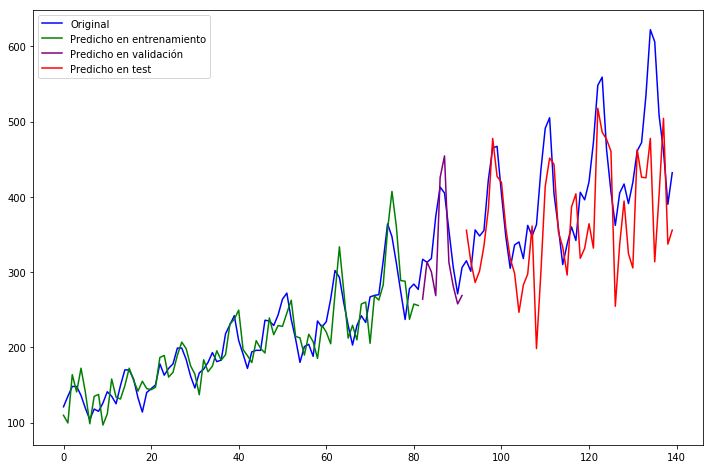

=============== Dropout = 0.400 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.4000) before linear
Test RMSE:  93.65583074445587val loss = 0.01161


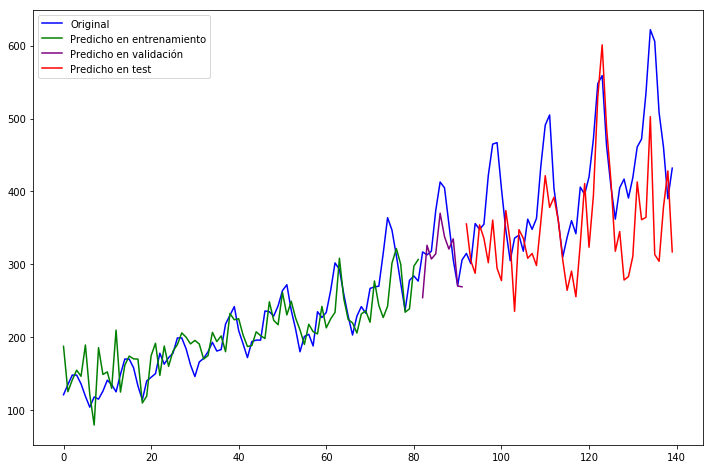

=============== Dropout = 0.500 ================
Size of train/val/test:  82 10 48
RNN_modificado: using dropout(0.5000) before linear
Test RMSE:  93.65624992262055val loss = 0.01212


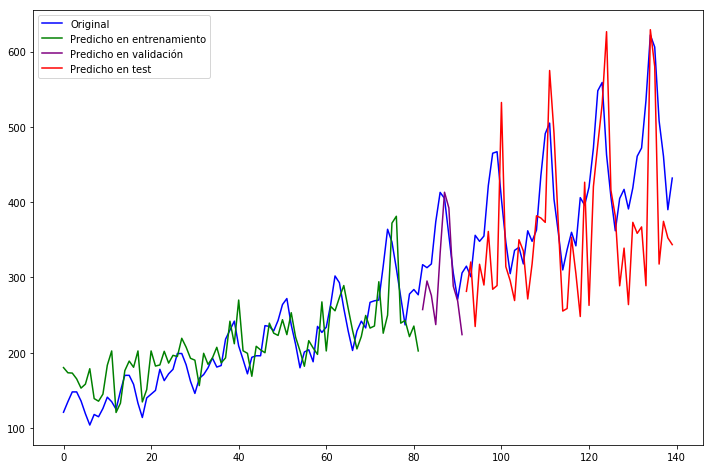

In [62]:
for dropout in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print('=============== Dropout = %.3f ================' % dropout)
    main_modificado(dropout=dropout)

Como vemos, el mejor resultado se obtuvo con dropout = 0.05, con un Test RMSE de 59.11, mayores niveles de dropout tienden a perjudicar el desempeño del modelo al hacer el entrenamiento demasiado ruidoso.

# Actividad 3

In [74]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, use_dense=False, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        c0 = self.init_control(batch_size)
        _, (hn, cn) = self.lstm(input.unsqueeze(2), (h0,c0))
        out = self.linear_out(hn.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden
    
    def init_control(self, batch_size):
        control = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return control

In [75]:
def main_LSTM():
    # A continuación se definen un par de constantes
    HISTORY_LENGTH=4
    DATASET_PATH = "international-airline-passengers.csv"
    TEST_START_IDX = 96 - HISTORY_LENGTH
    VAL_SPLIT = 0.1    

    INPUT_DIM = 1
    HIDDEN_DIM = 4
    NUM_LAYERS = 1

    EPOCHS = 1000
    BATCH_SIZE = 8
    LEARNING_RATE = 0.005

    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador
    rnn = LSTM(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
    )
    rnn.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            if (len(predicted.shape) > 1):
                predicted = predicted.squeeze()
            loss = criterion(predicted, target)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                if (len(predicted.shape) > 1):
                    predicted = predicted.squeeze()                                
                loss = criterion(predicted, target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 10 == 0:
            print("Epoch #{:>04d}: loss = {:.5f}; val loss = {:.5f}".format(
                epoch, mean_train_loss, mean_val_loss), end='\r', flush=True)

    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            if (len(predicted.shape) > 1):
                predicted = predicted.squeeze()            
            predictions += predicted.tolist()
            loss = criterion(predicted, target)
            targets += target.tolist()            
            losses.append(loss.item())
        mean_loss = np.mean(losses)    
        
    # Mostrar resultados
    display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
    )

### Corremos varias veces la LSTM

Size of train/val/test:  82 10 48
Test RMSE:  93.26260060345379val loss = 0.00622


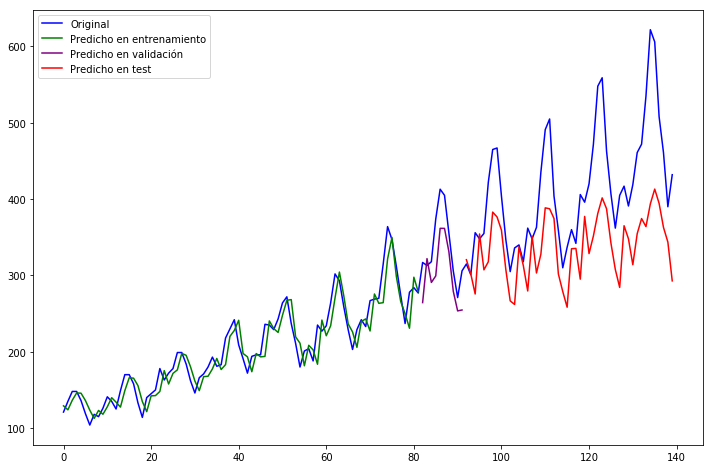

Size of train/val/test:  82 10 48
Test RMSE:  84.3317920346788 val loss = 0.00364


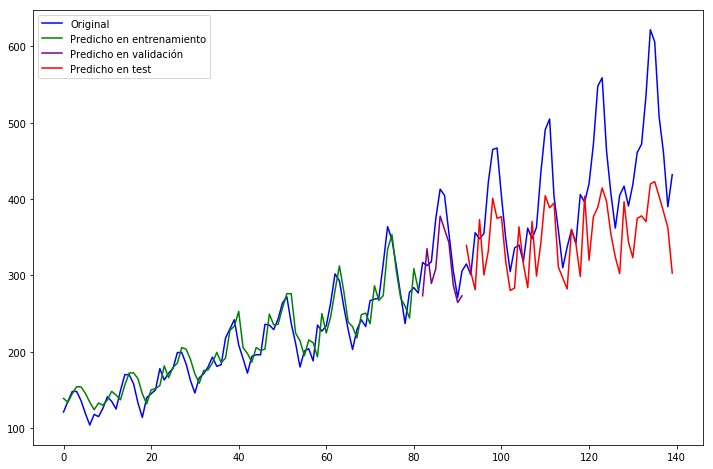

Size of train/val/test:  82 10 48
Test RMSE:  68.55112210928608val loss = 0.00454


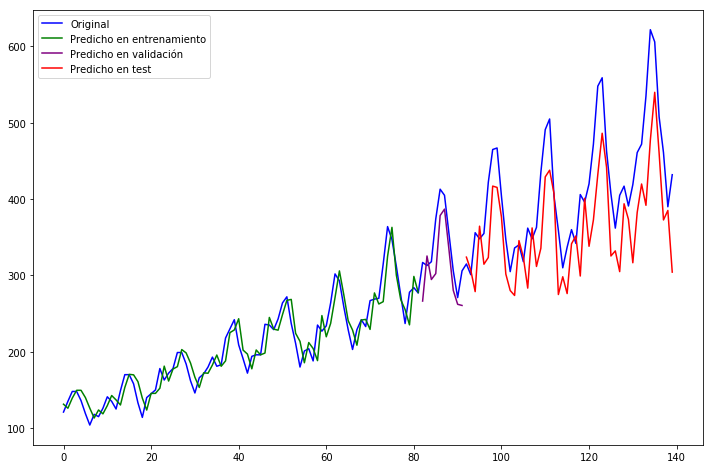

Size of train/val/test:  82 10 48
Test RMSE:  73.39415265141099val loss = 0.00432


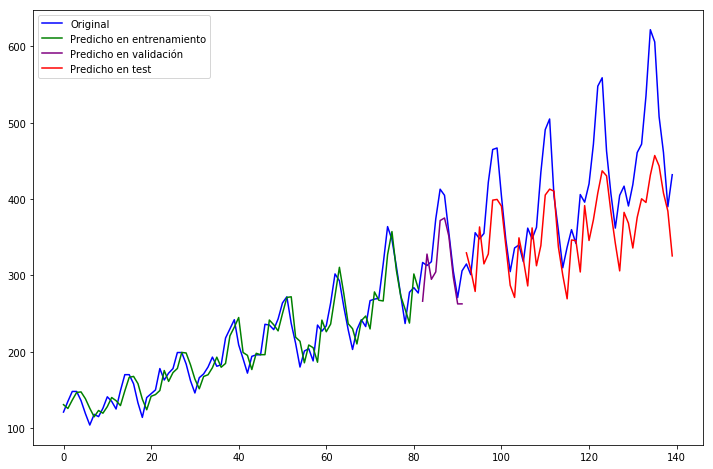

Size of train/val/test:  82 10 48
Test RMSE:  66.45619530947243val loss = 0.00399


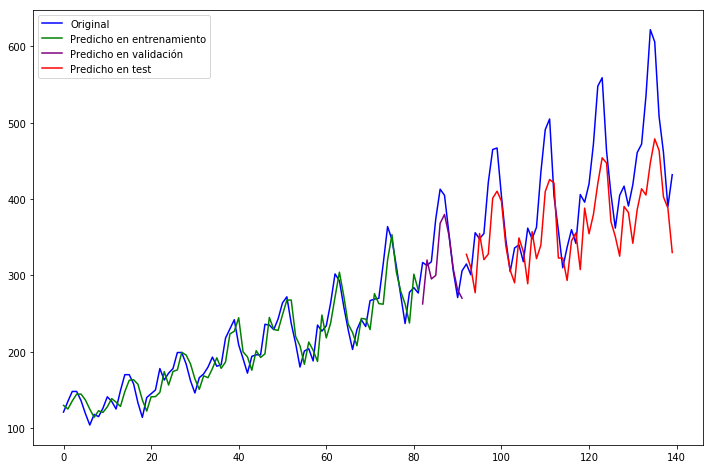

In [77]:
for _ in range(5):
    main_LSTM()

Notamos que los resultados no son muy distintos a los obtenidos por la RNN. Como vemos, distintas corridas de la LSTM producen distintos resultados, debido a la sensibilidad del entrenamiento respecto a la inicialización aleatoria de los pesos y quizás también al shuffle del dataset (que como se mencionó anteriormente son las dos fuentes de aleatoriedad). Quizás si el dataset fuese más grande y usaramos history lengths más largos la LSTM podría sacar a relucir su mayor capacidad.

Respecto a la cantidad de variables, la LSTM usa las siguientes ecuaciones:

$$i_t=\sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{(t-1)}+b_{hi}$$
$$f_t=\sigma(W_{if}x_t + b_{if} + W_{hf}h_{(t-1)}+b_{hf}$$
$$g_t=\text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{(t-1)}+b_{hg}$$
$$o_t=\sigma(W_{io}x_t + b_{io} + W_{ho}h_{(t-1)}+b_{ho}$$
$$c_t=f_t * c_{(t-1)} +i_t*g_t$$
$$h_t=o_t*\text{tanh}(c_t)$$

(fuente: https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)

Por lo tanto, usando un hidden state de largo 4, tenemos que $W_{ii}$, $W_{if}$, $W_{ig}$ y $W_{io}$ son de 4x1, $W_{hi}$, $W_{hf}$, $W_{hg}$ y $W_{ho}$ son de 4x4, $b_{ii}$, $b_{if}$, $b_{ig}$, $b_{io}$, $b_{hi}$, $b_{hf}$, $b_{hg}$ y $b_{ho}$ son todos de 4x1. Además, si consideramos el nn.Linear que conecta $h_n$ a un score final, tenemos una matriz de 4 y un bias de 1. Sumando, tenemos que hay 4x4 + 16x4 + 4x8 + 4 + 1 = 117 variables.

Comprobando empíricamente:

In [81]:
model = LSTM(1, 4, 1)
num_trainable_parameters(model)

117